# Análisis exploratorio

En este notebook vamos a realizar un análisis exploratorio que nos ayude a entender cómo se ha dado en el espacio la pandemia de COVID-19 en México. Intuitivamente la difusión de una epidemia es un fenómenos espacial, la enfermedad se transmite a través del contacto personal y, por lo tanto, es de esperarse que su evolución tenga una componente geográfica, es decir, que se observen estructuras espaciales (desde luego la estructura de contacto es más compleja dadas las redes de comunicación y comercio que existen).

En este análisis exploratorio vamos a hacer tres cosas, primero, examinar hasta qué punto podemos afirmar que la evolución de la pandemia en México ha seguido un patrón geográfico, interpretando esto como un patrón que muestre relación entre la incidencia de casos en un municpio y sus municipios vecinos.En segundo lugar, vamos a identificar los conglomerados locales de difusión de la enfermedad y, finalmente, haremos un análisis de la relación de dichos conglomerados locales con el índice de vulnerabilidad para tratar de identificar municipios que están en especial peligro.

Para correr el Notebook en colab necesitamos instalar las dependencias:

````
# Important library for many geopython libraries
!apt install gdal-bin python-gdal python3-gdal 
# Install rtree - Geopandas requirment
!apt install python3-rtree 
# Install Geopandas
!pip install git+git://github.com/geopandas/geopandas.git
# Install descartes - Geopandas requirment
!pip install descartes 
# Install Folium for Geographic data visualization
!pip install folium
# Install plotlyExpress
!pip install mapclassify
!pip install palettable
!pip install libpysal
!pip install esda
````


In [52]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import pandas as pd
from libpysal.weights import W,Queen, Rook, KNN, DistanceBand, min_threshold_distance, block_weights, lag_spatial
import esda
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import mapclassify
import contextily as ctx
# from libpysal.weights.contiguity import Queen
# import numpy as np
# import pandas as pd
# import geopandas as gpd
# import os
# import glob

# from esda.moran import Moran, Moran_Local, Moran_Local_BV
# from PIL import Image
# import seaborn as sns
# import sys

plt.style.use('ggplot')

## Asociacion espacial I de Moran

Para tener un primer estimado de qué tan _agrupada_ en el espacio ha sucedido la pandemia, vamos a hacer una serie de tiempo de la I de Moran a nivel municipal, tanto para la tasa de casos confirmados como para la tasa de defunciones.


Primero vamos a leer los datos y hacer agregados para cada semana epidemiológica (vamos a hacer el análisis temporal con base en semanas para evitar el ruido contenido en la variación diaria)

Otra vez vamos a comenzar con la base de acumulados por semana, para descargarla en colab:

````Python
url = "https://www.dropbox.com/s/kf9dldnqgo4eidu/agregados_semana_municipio.pkl?dl=1"
r = requests.get(url, allow_redirects=True)
open('/content/semana_municipio.pkl', 'wb').write(r.content)

url = "https://www.dropbox.com/s/46h5pnrhgnw9qca/pca_vulnerability.csv?dl=1"
r = requests.get(url, allow_redirects=True)
open('/content/pca_vulnerability.csv', 'wb').write(r.content)

url = "https://www.dropbox.com/s/46h5pnrhgnw9qca/pca_vulnerability.csv?dl=1"
r = requests.get(url, allow_redirects=True)
open('/content/pca_vulnerability.csv', 'wb').write(r.content)

https://www.dropbox.com/s/md8gl5oy3mpequg/municipios.gpkg?dl=0
````


In [13]:
confirmados_por_semana = pd.read_pickle("data/semana_municipio.pkl")
confirmados_por_semana.head()

Nuevos Casos  \
FECHA_SINTOMAS CLAVE_MUNICIPIO_RES MUNICIPIO_RES                       
2020-01-05     01001               AGUASCALIENTES                 11   
               01006               PABELLÓN DE ARTEAGA             1   
               01009               TEPEZALÁ                        1   
               02001               ENSENADA                        1   
               02002               MEXICALI                       11   

                                                        Defunciones  
FECHA_SINTOMAS CLAVE_MUNICIPIO_RES MUNICIPIO_RES                     
2020-01-05     01001               AGUASCALIENTES                 0  
               01006               PABELLÓN DE ARTEAGA            0  
               01009               TEPEZALÁ                       0  
               02001               ENSENADA                       0  
               02002               MEXICALI                       0

También vamos a necesitar las geometrías de los municipios y su población

In [83]:
muns_geo = gpd.read_file("data/municipios.gpkg")
muns_geo.head()

,_uid_,entidad_cvegeo,municipio_cvegeo,municipio_nombre,pob,geometry
0,1,16,16046,Juárez,15290.0,"MULTIPOLYGON (((-100.45897 19.32952, -100.4588..."
1,2,16,16047,Jungapeo,22358.0,"MULTIPOLYGON (((-100.55704 19.51833, -100.5561..."
2,3,16,16048,Lagunillas,5862.0,"MULTIPOLYGON (((-101.38110 19.60250, -101.3811..."
3,4,16,16049,Madero,18769.0,"MULTIPOLYGON (((-101.11654 19.53720, -101.1168..."
4,5,05,05035,Torreón,744247.0,"MULTIPOLYGON (((-103.42797 25.30109, -103.3861..."


En `confirmados_por_semana` tenemos los casos y defunciones nuevas por cada semana, entonces tenemos que acumularlos a lo largo de las semanas para tener los totales acumulados

<AxesSubplot:xlabel='FECHA_SINTOMAS'>

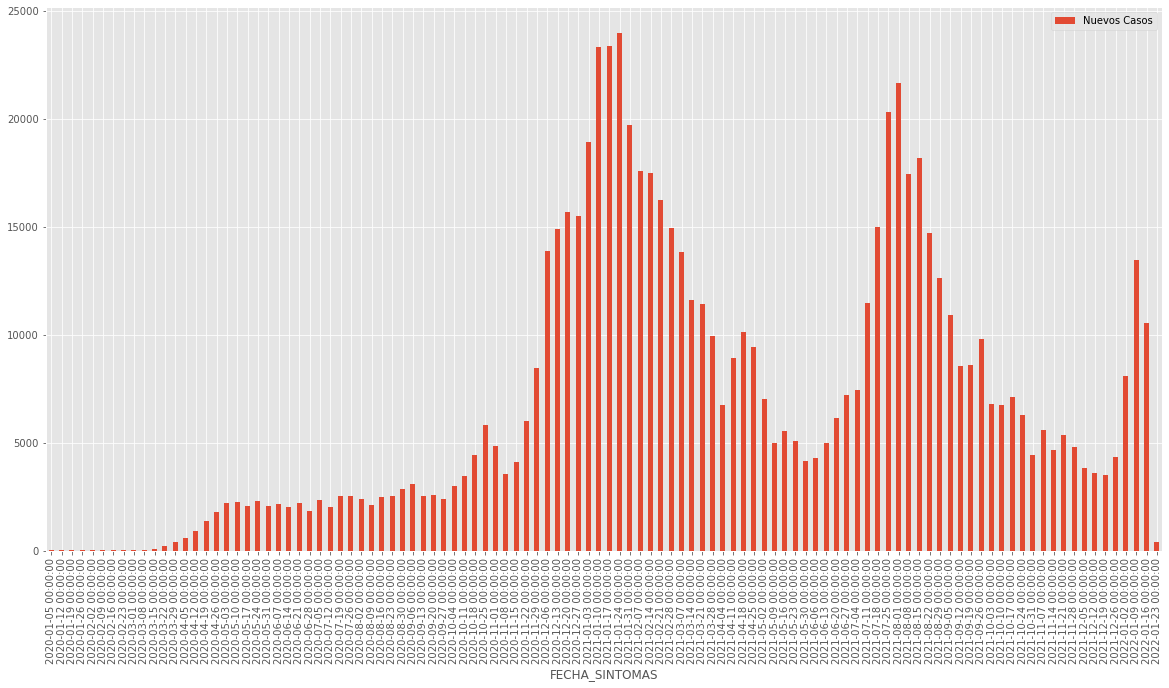

In [15]:
casos_por_semana = confirmados_por_semana.groupby(['CLAVE_MUNICIPIO_RES','FECHA_SINTOMAS'])[['Nuevos Casos']].sum()
casos_por_semana.xs('09007', level=0)[['Nuevos Casos']].plot(kind='bar', figsize=(20,10))

Y lo mismo para las defunciones

<AxesSubplot:xlabel='FECHA_SINTOMAS'>

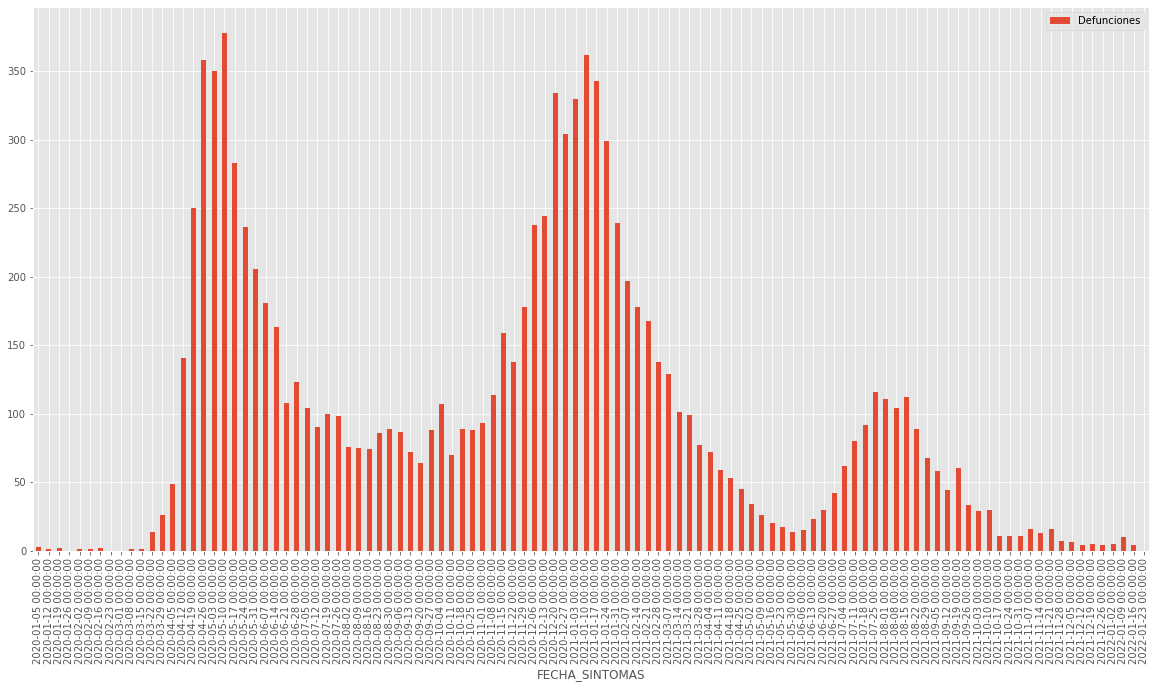

In [16]:
defunciones_por_semana = confirmados_por_semana.groupby(['CLAVE_MUNICIPIO_RES','FECHA_SINTOMAS'])[['Defunciones']].sum()
defunciones_por_semana.xs('09007', level=0)[['Defunciones']].plot(kind='bar', figsize=(20,10))

### Autocorrelación para casos confirmados

Tenemos, por un lado, las geometrías (y poblaciones) de los municipios y, por otro lado, las series de tiempo de casos confirmados. Para calcular la I de Moran (o clusters de LISA) necesitamos tener las dos cosas unidas, por la forma en la que funcionan los métodos de PySal, lo más fácil es tener los datos en _forma ancha_, es decir, una columna por cada semana. 

In [18]:
confirmados_por_semana_wide = (confirmados_por_semana
                   .reset_index()
                   .pivot_table("Nuevos Casos", "CLAVE_MUNICIPIO_RES", "FECHA_SINTOMAS")
                  )
confirmados_por_semana_wide.head()

FECHA_SINTOMAS,2020-01-05,2020-01-12,2020-01-19,2020-01-26,2020-02-02,2020-02-09,2020-02-16,2020-02-23,2020-03-01,2020-03-08,...,2021-11-21,2021-11-28,2021-12-05,2021-12-12,2021-12-19,2021-12-26,2022-01-02,2022-01-09,2022-01-16,2022-01-23
CLAVE_MUNICIPIO_RES,,,,,,,,,,,,,,,,,,,,,
01001,11.0,42.0,78.0,72.0,48.0,75.0,61.0,63.0,72.0,56.0,...,1271.0,1264.0,1333.0,1336.0,1457.0,1664.0,3018.0,3434.0,1325.0,10.0
01002,NaN,1.0,5.0,NaN,1.0,1.0,2.0,2.0,1.0,NaN,...,18.0,16.0,17.0,8.0,1.0,9.0,41.0,32.0,16.0,NaN
01003,NaN,3.0,5.0,4.0,1.0,3.0,4.0,6.0,5.0,2.0,...,40.0,25.0,42.0,44.0,42.0,76.0,56.0,53.0,15.0,NaN
01004,NaN,NaN,NaN,NaN,1.0,NaN,1.0,1.0,1.0,NaN,...,4.0,11.0,5.0,2.0,2.0,4.0,7.0,21.0,2.0,NaN
01005,NaN,5.0,2.0,4.0,1.0,1.0,2.0,6.0,3.0,6.0,...,41.0,43.0,37.0,41.0,64.0,115.0,123.0,185.0,107.0,NaN


Unimos con las geometrías de los municipios, tenemos que usar un right join y rellenar con ceros porque no todos los municipios tienen casos

In [20]:
confirmados_por_semana_wide = (confirmados_por_semana_wide
                   .merge(muns_geo, left_on='CLAVE_MUNICIPIO_RES', right_on='municipio_cvegeo', how='right')
                   .fillna(0))

confirmados_por_semana_wide.head()

,2020-01-05 00:00:00,2020-01-12 00:00:00,2020-01-19 00:00:00,2020-01-26 00:00:00,2020-02-02 00:00:00,2020-02-09 00:00:00,2020-02-16 00:00:00,2020-02-23 00:00:00,2020-03-01 00:00:00,2020-03-08 00:00:00,...,2022-01-02 00:00:00,2022-01-09 00:00:00,2022-01-16 00:00:00,2022-01-23 00:00:00,_uid_,entidad_cvegeo,municipio_cvegeo,municipio_nombre,pob,geometry
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,9.0,2.0,2.0,0.0,1,16,16046,Juárez,15290.0,"MULTIPOLYGON (((-100.45897 19.32952, -100.4588..."
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,3.0,1.0,3.0,0.0,2,16,16047,Jungapeo,22358.0,"MULTIPOLYGON (((-100.55704 19.51833, -100.5561..."
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,2.0,0.0,3,16,16048,Lagunillas,5862.0,"MULTIPOLYGON (((-101.38110 19.60250, -101.3811..."
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,4,16,16049,Madero,18769.0,"MULTIPOLYGON (((-101.11654 19.53720, -101.1168..."
4,3.0,17.0,34.0,59.0,52.0,68.0,62.0,40.0,42.0,28.0,...,1431.0,2768.0,1759.0,13.0,5,05,05035,Torreón,744247.0,"MULTIPOLYGON (((-103.42797 25.30109, -103.3861..."


Con estos datos ya podemos calcular la I de Morán para cualquier semana. Como la matriz de pesos es la misma siempre, la podemos calcular antes

In [21]:
w = Queen.from_dataframe(confirmados_por_semana_wide)
w.T = 'r' # estandarizamos por fila
w.n

/home/plablo/miniconda3/envs/geoinformatica/lib/python3.10/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
 There is 1 island with id: 1986.
  warnings.warn(message)


2457

Hay una isla en los datos!

In [24]:
confirmados_por_semana_wide.iloc[1986]

/home/plablo/miniconda3/envs/geoinformatica/lib/python3.10/site-packages/pandas/core/dtypes/inference.py:383: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  iter(obj)  # Can iterate over it.
/home/plablo/miniconda3/envs/geoinformatica/lib/python3.10/site-packages/pandas/core/dtypes/inference.py:384: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  len(obj)  # Has a length associated with it.
/home/plablo/miniconda3/envs/geoinformatica/lib/python3.10/site-packages/pandas/io/formats/printing.py:117: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a mu

2020-01-05 00:00:00                                                  2.0
2020-01-12 00:00:00                                                  3.0
2020-01-19 00:00:00                                                  1.0
2020-01-26 00:00:00                                                  0.0
2020-02-02 00:00:00                                                  1.0
                                             ...                        
entidad_cvegeo                                                        23
municipio_cvegeo                                                   23001
municipio_nombre                                                 Cozumel
pob                                                             101106.0
geometry               (POLYGON ((-87.35445532037998 20.3160732899774...
Name: 1986, Length: 114, dtype: object

Claro, Cozumel es una isla, para que no moleste, la quitamos de los municipios y volvemos a calcular la matriz de contiguidad

In [25]:
confirmados_por_semana_wide = confirmados_por_semana_wide.drop([1986], axis=0)
w = Queen.from_dataframe(confirmados_por_semana_wide)
w.T = 'r' # estandarizamos por fila
w.n

/home/plablo/miniconda3/envs/geoinformatica/lib/python3.10/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


2456

Para calcular la I de Moran para una semana en específico:

In [27]:
y = confirmados_por_semana_wide[pd.to_datetime('2020-06-21 00:00:00')] / confirmados_por_semana_wide['pob']
moran_c = esda.Moran(y,w)
print("La I de Moran para la tasa de confirmados es: ", moran_c.I)
print("Su significancia : ", moran_c.p_sim)

La I de Moran para la tasa de confirmados es:  0.1787960054006309
Su significancia :  0.001


Calculamos la I de Moran sobre la tasa en lugar de sobre el total de casos para poder controlar por población (de lo contrario en realidad estaríamos viendo conglomerados de población). Ahora lo que queremos es sacar la serie de tiempo para la I de Moran de la tasa de casos confirmados para ver cómo ha evolucionado la aglomeración espacial de los casos. 

In [30]:
semanas_estudio = list(confirmados_por_semana_wide.columns)
semanas_estudio = [pd.to_datetime(s) for s in semanas_estudio 
                   if s not in ['municipio_cvegeo', '_uid_', 'entidad_cvegeo', 'municipio_nombre', 'pob', 'geometry']]
serie_moran_confirmados = []
for s in semanas_estudio:
    y = confirmados_por_semana_wide[s] / confirmados_por_semana_wide['pob']
    moran = esda.Moran(y,w, permutations=1000)
    serie_moran_confirmados.append((s,moran.I, moran.p_sim))
df_moran_confirmados = pd.DataFrame(serie_moran_confirmados).rename({0:'fecha', 1:'I', 2:'p'}, axis=1)
df_moran_confirmados

,fecha,I,p
0,2020-01-05,0.053150,0.012987
1,2020-01-12,0.041410,0.009990
2,2020-01-19,0.149282,0.000999
3,2020-01-26,0.150730,0.000999
4,2020-02-02,0.074333,0.001998
...,...,...,...
103,2021-12-26,0.384129,0.000999
104,2022-01-02,0.459342,0.000999
105,2022-01-09,0.224979,0.000999
106,2022-01-16,0.437770,0.000999


La I para las primeras semanas no es significativa, entonces seleccionemos sólo los valores con $p > 0.05$

In [32]:
df_moran_confirmados = df_moran_confirmados[df_moran_confirmados['p'] < 0.05]
df_moran_confirmados

,fecha,I,p
0,2020-01-05,0.053150,0.012987
1,2020-01-12,0.041410,0.009990
2,2020-01-19,0.149282,0.000999
3,2020-01-26,0.150730,0.000999
4,2020-02-02,0.074333,0.001998
...,...,...,...
103,2021-12-26,0.384129,0.000999
104,2022-01-02,0.459342,0.000999
105,2022-01-09,0.224979,0.000999
106,2022-01-16,0.437770,0.000999


Graficamos

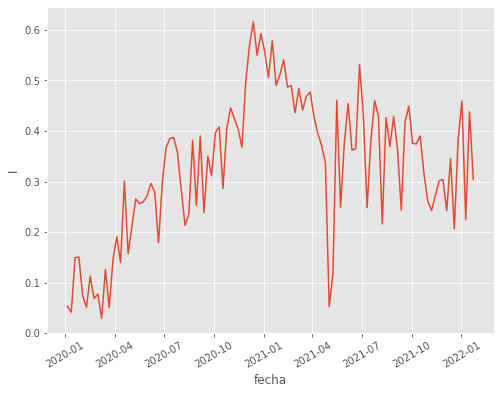

In [34]:
plt.figure(figsize=(8,6))
g = sns.lineplot(x="fecha", y="I", data=df_moran_confirmados)
g = plt.setp(g.get_xticklabels(), rotation=30)

### Autocorrelación para la tasa de defunción

Ahora vamos a repetir el análisis pero para la tasa de defunción.

In [37]:
defunciones_por_semana_wide = (defunciones_por_semana
                   .reset_index()
                   .pivot_table("Defunciones", "CLAVE_MUNICIPIO_RES", "FECHA_SINTOMAS")
                  )
defunciones_por_semana_wide = (defunciones_por_semana_wide
                   .merge(muns_geo, left_on='CLAVE_MUNICIPIO_RES', right_on='municipio_cvegeo', how='right')
                   .fillna(0))

defunciones_por_semana_wide.head()

,2020-01-05 00:00:00,2020-01-12 00:00:00,2020-01-19 00:00:00,2020-01-26 00:00:00,2020-02-02 00:00:00,2020-02-09 00:00:00,2020-02-16 00:00:00,2020-02-23 00:00:00,2020-03-01 00:00:00,2020-03-08 00:00:00,...,2022-01-02 00:00:00,2022-01-09 00:00:00,2022-01-16 00:00:00,2022-01-23 00:00:00,_uid_,entidad_cvegeo,municipio_cvegeo,municipio_nombre,pob,geometry
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1,16,16046,Juárez,15290.0,"MULTIPOLYGON (((-100.45897 19.32952, -100.4588..."
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2,16,16047,Jungapeo,22358.0,"MULTIPOLYGON (((-100.55704 19.51833, -100.5561..."
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3,16,16048,Lagunillas,5862.0,"MULTIPOLYGON (((-101.38110 19.60250, -101.3811..."
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,4,16,16049,Madero,18769.0,"MULTIPOLYGON (((-101.11654 19.53720, -101.1168..."
4,0.0,1.0,0.0,1.0,0.0,2.0,1.0,0.0,0.0,0.0,...,5.0,15.0,5.0,0.0,5,05,05035,Torreón,744247.0,"MULTIPOLYGON (((-103.42797 25.30109, -103.3861..."


In [38]:
defunciones_por_semana_wide = defunciones_por_semana_wide.drop([1986], axis=0)
w = Queen.from_dataframe(defunciones_por_semana_wide)
w.T = 'r' # estandarizamos por fila
w.n

/home/plablo/miniconda3/envs/geoinformatica/lib/python3.10/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


2456

In [40]:
y = defunciones_por_semana_wide[pd.to_datetime('2020-06-21 00:00:00')] / defunciones_por_semana_wide['pob']
moran_d = esda.Moran(y,w)
print("La I de Moran para la tasa de confirmados es: ", moran_d.I)
print("Su significancia : ", moran_d.p_sim)

La I de Moran para la tasa de confirmados es:  0.10981410301250052
Su significancia :  0.001


Finalmente, la serie de tiempo

In [41]:
semanas_estudio = list(defunciones_por_semana_wide.columns)
semanas_estudio = [pd.to_datetime(s) for s in semanas_estudio 
                   if s not in ['municipio_cvegeo', '_uid_', 'entidad_cvegeo', 'municipio_nombre', 'pob', 'geometry']]
serie_moran_defunciones = []
for s in semanas_estudio:
    y = defunciones_por_semana_wide[s] / defunciones_por_semana_wide['pob']
    moran = esda.Moran(y,w, permutations=1000)
    serie_moran_defunciones.append((s,moran.I, moran.p_sim))
df_moran_defunciones = pd.DataFrame(serie_moran_defunciones).rename({0:'fecha', 1:'I', 2:'p'}, axis=1)
df_moran_defunciones

/home/plablo/miniconda3/envs/geoinformatica/lib/python3.10/site-packages/esda/moran.py:226: RuntimeWarning: invalid value encountered in double_scalars
  k = k_num / k_den
/home/plablo/miniconda3/envs/geoinformatica/lib/python3.10/site-packages/esda/moran.py:237: RuntimeWarning: invalid value encountered in double_scalars
  return self.n / self.w.s0 * inum / self.z2ss
/home/plablo/miniconda3/envs/geoinformatica/lib/python3.10/site-packages/esda/moran.py:201: RuntimeWarning: invalid value encountered in true_divide
  self.z /= sy


,fecha,I,p
0,2020-01-05,-0.000091,0.147852
1,2020-01-12,-0.000723,0.222777
2,2020-01-19,-0.003454,0.488511
3,2020-01-26,-0.001503,0.362637
4,2020-02-02,0.062484,0.002997
...,...,...,...
103,2021-12-26,0.026304,0.033966
104,2022-01-02,0.069430,0.001998
105,2022-01-09,0.014600,0.055944
106,2022-01-16,0.001105,0.161838


Seleccionamos los estadísticamente significativos y graficamos

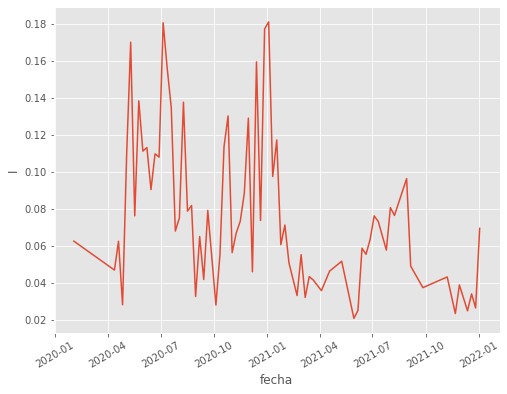

In [42]:
df_moran_defunciones = df_moran_defunciones[df_moran_defunciones['p'] < 0.05]
plt.figure(figsize=(8,6))
g = sns.lineplot(x="fecha", y="I", data=df_moran_defunciones)
g = plt.setp(g.get_xticklabels(), rotation=30)

Tenemos datos significativos para menos semanas y se observa una menor estructura espacial (I más pequeña), aunque de todos modos es significativa y positiva.
De alguna forma es un resultado esperado, la tasa de casos confirmados está diréctamente relacionada con el contacto entre personas, para lo cual la proximidad es un _proxy_, sin embargo la tasa de defunciones está mediada por otras características locales como la capacidad del sistema hospitalario y las comorbilidades de la población.

Ahora vamos a explorar las estructuras locales.

## Indicadores Locales de Asociación Espacial (LISA)

La I de Moran es un indicador _global_ de la Asociación espacial, sin embargo también es importante tener una idea de los conglomerados locales. Pra esto usamos LISA, que encuentra diferentes tipos de clusters locales. Como vimos arriba, la autocorrelación espacial cambia en el tiempo, de igual forma los conglomerados locales tabién pueden variar. En el siguiente Notebook vamos a estudiuar esta variación, por lo pronto veamos cómo son los conglomerados para la una semana específica. 

### Conglomerados para la tasa de confirmados

In [48]:
ultima_confirmados = confirmados_por_semana_wide[[pd.to_datetime('2021-01-03'), 'municipio_cvegeo', 'geometry', 'pob']].copy()
ultima_confirmados['tasa'] = ultima_confirmados[pd.to_datetime('2021-01-03')] / ultima_confirmados['pob']
ultima_confirmados.drop(pd.to_datetime('2021-01-03'), axis=1, inplace=True)
lisa_confirmados = esda.Moran_Local.by_col(ultima_confirmados,'tasa',  w, permutations=10000, outvals=['q'])
# lisa_ultima = lisa_ultima.loc[:,['municipio_cvegeo', 'geometry', 'tasa,', 'tasa_p_sim', 'tasa_q']]
lisa_confirmados.rename({'tasa_q': 'cluster'}, inplace=True, axis=1)
lisa_confirmados.loc[lisa_confirmados['tasa_p_sim'] >= 0.05, 'cluster'] = -4
lisa_confirmados = gpd.geodataframe.GeoDataFrame(lisa_confirmados)
lisa_confirmados.crs = 'EPSG:4326'
lisa_confirmados['cluster'] = lisa_confirmados['cluster'].replace({1: 'HH', 2: 'LH', 3:'LL', 4:'HL', -4:'NS'})
lisa_confirmados.head()

,municipio_cvegeo,geometry,pob,tasa,tasa_moran_local,cluster,tasa_p_sim
0,16046,"MULTIPOLYGON (((-100.45897 19.32952, -100.4588...",15290.0,0.001766,-0.028117,NS,0.354065
1,16047,"MULTIPOLYGON (((-100.55704 19.51833, -100.5561...",22358.0,0.000358,-0.049257,NS,0.135186
2,16048,"MULTIPOLYGON (((-101.38110 19.60250, -101.3811...",5862.0,0.000512,0.004639,NS,0.459154
3,16049,"MULTIPOLYGON (((-101.11654 19.53720, -101.1168...",18769.0,0.000266,0.019466,NS,0.462254
4,05035,"MULTIPOLYGON (((-103.42797 25.30109, -103.3861...",744247.0,0.000997,-0.039253,NS,0.473653


Hacemos el mapa

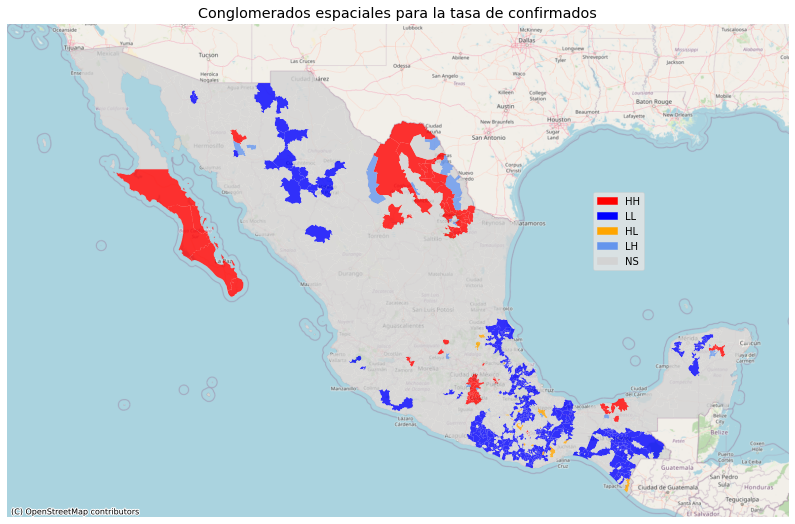

In [53]:
color_dict = {'HH':'red', 'LL':'blue', 'HL':'orange', 'LH':'cornflowerblue', 'NS':'lightgray'}
fig, ax = plt.subplots(figsize=(14, 16))
for ctype, data in lisa_confirmados.groupby('cluster'):
    color = color_dict[ctype]
    # Plot each group using the color defined above
    data.to_crs(epsg=3857).plot(color=color,
              ax=ax,
              label=ctype,
              alpha=0.8 )

red_patch = mpatches.Patch(color='red', label='HH')
blue_patch = mpatches.Patch(color='blue', label='LL')
orange_patch = mpatches.Patch(color='orange', label='HL')
lblue_patch = mpatches.Patch(color='cornflowerblue', label='LH')
gray_patch = mpatches.Patch(color='lightgray', label='NS')
plt.legend(handles=[red_patch, blue_patch, orange_patch, lblue_patch, gray_patch], loc=(0.75,0.5))
ax.set(title='Conglomerados espaciales para la tasa de confirmados')
ax.set_axis_off()
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
plt.show()

Se encuentran los siguientes conglomerados:

* HH Valores altos de tasa de confiirmados en vecindades de valores altos, este tipo de conglomerado se conoce como _Hot Spot_
* LL Valores bajos de la tasa en vecindades con valores bajos, estos se llaman _Cold Spots_
* HL Valores altos en vecindades con valores bajos
* LH Valores bajos en vacindades con valores altos

Los conglomerados HH representan lugares donde se tiene una clara difusión espacial de la epidemia, mientra que los HH son lugares donde aún no se pŕesentan casos de forma significativa. Los calsos más interesantes son los HL y LH ya que ahí se vew una diferencia siginifcativa en la incidencia en municipios vecinos, son lugares en donde una intervensión puntual podría tener un efecto importante.

### Conglomerados para la tasa de defunciones

In [54]:
w = Queen.from_dataframe(defunciones_por_semana_wide)
w.T = 'r' # estandarizamos por fila
ultima_defunciones = defunciones_por_semana_wide[[pd.to_datetime('2021-01-03'), 'municipio_cvegeo', 'geometry', 'pob']].copy()
ultima_defunciones['tasa'] = ultima_defunciones[pd.to_datetime('2021-01-03')] / ultima_defunciones['pob']
ultima_defunciones.drop(pd.to_datetime('2021-01-03'), axis=1, inplace=True)
lisa_defunciones = esda.Moran_Local.by_col(ultima_defunciones,'tasa',  w, permutations=10000, outvals=['q'])
# lisa_ultima = lisa_ultima.loc[:,['municipio_cvegeo', 'geometry', 'tasa,', 'tasa_p_sim', 'tasa_q']]
lisa_defunciones.rename({'tasa_q': 'cluster'}, inplace=True, axis=1)
lisa_defunciones.loc[lisa_defunciones['tasa_p_sim'] >= 0.05, 'cluster'] = -4
lisa_defunciones = gpd.geodataframe.GeoDataFrame(lisa_defunciones)
lisa_defunciones.crs = 'EPSG:4326'
lisa_defunciones['cluster'] = lisa_defunciones['cluster'].replace({1: 'HH', 2: 'LH', 3:'LL', 4:'HL', -4:'NS'})
lisa_defunciones.head()

/home/plablo/miniconda3/envs/geoinformatica/lib/python3.10/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


,municipio_cvegeo,geometry,pob,tasa,tasa_moran_local,cluster,tasa_p_sim
0,16046,"MULTIPOLYGON (((-100.45897 19.32952, -100.4588...",15290.0,0.000131,-0.240042,NS,0.334567
1,16047,"MULTIPOLYGON (((-100.55704 19.51833, -100.5561...",22358.0,0.000000,-0.034275,NS,0.310469
2,16048,"MULTIPOLYGON (((-101.38110 19.60250, -101.3811...",5862.0,0.000000,-0.053071,NS,0.284972
3,16049,"MULTIPOLYGON (((-101.11654 19.53720, -101.1168...",18769.0,0.000053,-0.003151,NS,0.427057
4,05035,"MULTIPOLYGON (((-103.42797 25.30109, -103.3861...",744247.0,0.000070,-0.056900,NS,0.378762


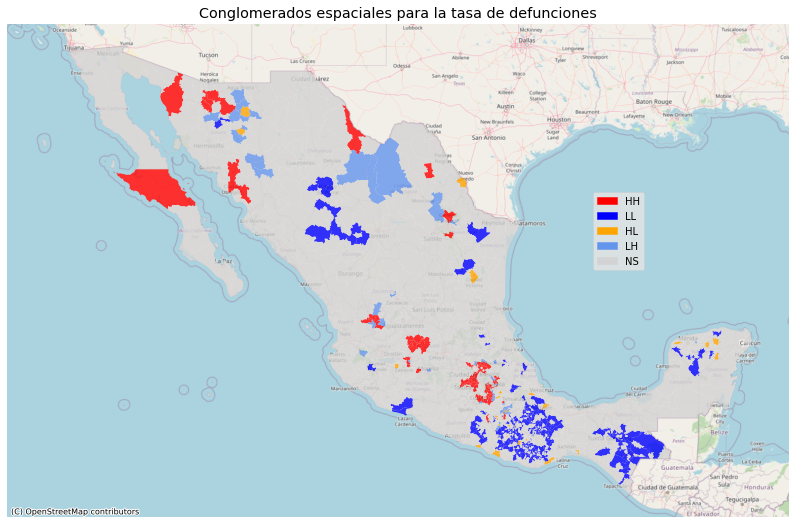

In [55]:
color_dict = {'HH':'red', 'LL':'blue', 'HL':'orange', 'LH':'cornflowerblue', 'NS':'lightgray'}
fig, ax = plt.subplots(figsize=(14, 16))
for ctype, data in lisa_defunciones.groupby('cluster'):
    color = color_dict[ctype]
    # Plot each group using the color defined above
    data.to_crs(epsg=3857).plot(color=color,
              ax=ax,
              label=ctype,
              alpha=0.8 )

red_patch = mpatches.Patch(color='red', label='HH')
blue_patch = mpatches.Patch(color='blue', label='LL')
orange_patch = mpatches.Patch(color='orange', label='HL')
lblue_patch = mpatches.Patch(color='cornflowerblue', label='LH')
gray_patch = mpatches.Patch(color='lightgray', label='NS')
plt.legend(handles=[red_patch, blue_patch, orange_patch, lblue_patch, gray_patch], loc=(0.75,0.5))
ax.set(title='Conglomerados espaciales para la tasa de defunciones')
ax.set_axis_off()
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
plt.show()

## Clusters locales bivariados

Finalmente, vamos a examinar los clusters locales bivariados usando como segunda variable un índice de vulnerabilidad. Los clusters bivariados miden las relaciones locales entre dos variables.


### Tasa de casos confirmados

Primero leemos el índice de vulnerabilidad y lo unimos a los datos

In [75]:
vulnerabilidad = pd.read_csv("data/pca_vulnerability.csv", dtype={"municipio_cvegeo":str})
bivariado_confirmados = lisa_confirmados.merge(vulnerabilidad, on='municipio_cvegeo', how='left')
bivariado_confirmados = bivariado_confirmados.drop(['tasa_moran_local', 'cluster', 'tasa_p_sim', 'Unnamed: 0'], axis=1)
bivariado_confirmados = bivariado_confirmados.fillna(0)
bivariado_confirmados.head()

,municipio_cvegeo,geometry,pob,tasa,pca_vulnerability
0,16046,"MULTIPOLYGON (((-100.45897 19.32952, -100.4588...",15290.0,0.001766,-0.706551
1,16047,"MULTIPOLYGON (((-100.55704 19.51833, -100.5561...",22358.0,0.000358,0.029110
2,16048,"MULTIPOLYGON (((-101.38110 19.60250, -101.3811...",5862.0,0.000512,-0.853268
3,16049,"MULTIPOLYGON (((-101.11654 19.53720, -101.1168...",18769.0,0.000266,1.054307
4,05035,"MULTIPOLYGON (((-103.42797 25.30109, -103.3861...",744247.0,0.000997,-4.141753


<AxesSubplot:>

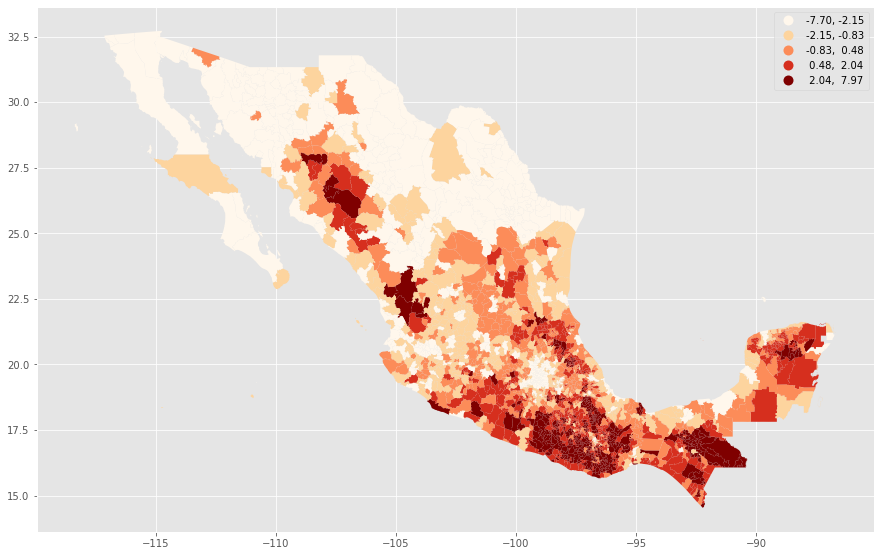

In [76]:
bivariado_confirmados.plot(column='pca_vulnerability', cmap='OrRd',figsize=(15, 10), scheme="quantiles", legend=True)

Queremos encontrar clusters locales en donde haya vecindades con alto número de casos rodeando a municipios con alta vulnerabilidad, entonces la variable para la que tenemos que calcular el retraso espacial es la tasa de confirmados.

Para asegurar que estamos calculando sobre la misma escala de medición, tenemos que estandarizar las variables que nos interesan a media 0 y varianza 1

In [77]:
bivariado_confirmados.loc[:,'tasa'] = (bivariado_confirmados['tasa'] - bivariado_confirmados['tasa'].mean())/bivariado_confirmados['tasa'].std()
bivariado_confirmados.loc[:,'pca_vulnerability'] = (bivariado_confirmados['pca_vulnerability'] - bivariado_confirmados['pca_vulnerability'].mean())/bivariado_confirmados['pca_vulnerability'].std()
bivariado_confirmados.head()

,municipio_cvegeo,geometry,pob,tasa,pca_vulnerability
0,16046,"MULTIPOLYGON (((-100.45897 19.32952, -100.4588...",15290.0,1.017059,-0.298178
1,16047,"MULTIPOLYGON (((-100.55704 19.51833, -100.5561...",22358.0,-0.166634,0.011827
2,16048,"MULTIPOLYGON (((-101.38110 19.60250, -101.3811...",5862.0,-0.037208,-0.360004
3,16049,"MULTIPOLYGON (((-101.11654 19.53720, -101.1168...",18769.0,-0.243485,0.443841
4,05035,"MULTIPOLYGON (((-103.42797 25.30109, -103.3861...",744247.0,0.370690,-1.745758


In [78]:
local_bivar_confirmados = esda.Moran_Local_BV.by_col(bivariado_confirmados,'pca_vulnerability', 'tasa', w, permutations=10000, outvals=['q'])
local_bivar_confirmados.rename({'pca_vulnerability-tasa_q': 'cluster'}, inplace=True, axis=1)
local_bivar_confirmados.loc[local_bivar_confirmados['pca_vulnerability-tasa_p_sim'] > 0.05, 'cluster'] = -4
local_bivar_confirmados['cluster'] = local_bivar_confirmados['cluster'].replace({1: 'HH', 2: 'LH', 3:'LL', 4:'HL', -4:'NS'})
local_bivar_confirmados = gpd.geodataframe.GeoDataFrame(local_bivar_confirmados)
local_bivar_confirmados.crs = "EPSG:4326"
local_bivar_confirmados.head()

,municipio_cvegeo,geometry,pob,tasa,pca_vulnerability,pca_vulnerability-tasa_moran_local_bv,cluster,pca_vulnerability-tasa_p_sim
0,16046,"MULTIPOLYGON (((-100.45897 19.32952, -100.4588...",15290.0,1.017059,-0.298178,0.008243,NS,0.368363
1,16047,"MULTIPOLYGON (((-100.55704 19.51833, -100.5561...",22358.0,-0.166634,0.011827,0.003496,NS,0.137386
2,16048,"MULTIPOLYGON (((-101.38110 19.60250, -101.3811...",5862.0,-0.037208,-0.360004,0.044881,NS,0.458854
3,16049,"MULTIPOLYGON (((-101.11654 19.53720, -101.1168...",18769.0,-0.243485,0.443841,-0.035485,NS,0.468853
4,05035,"MULTIPOLYGON (((-103.42797 25.30109, -103.3861...",744247.0,0.370690,-1.745758,0.184861,NS,0.484252


Hacemos un mapa

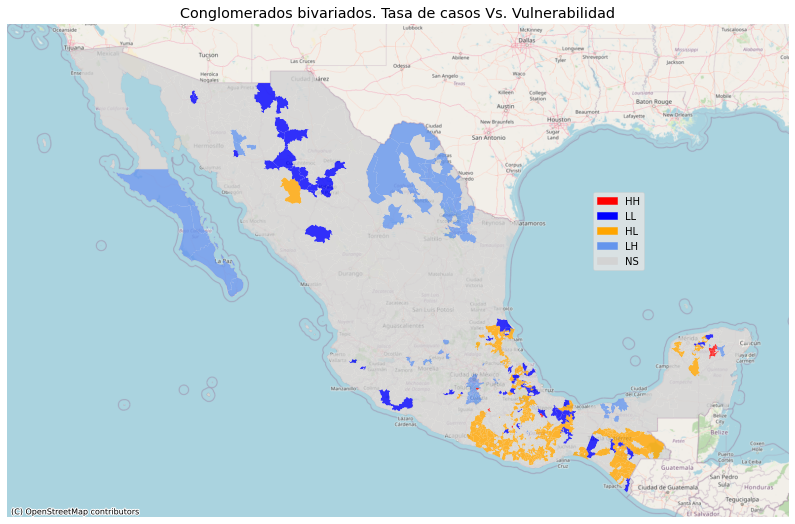

In [79]:
color_dict = {'HH':'red', 'LL':'blue', 'HL':'orange', 'LH':'cornflowerblue', 'NS':'lightgray'}
fig, ax = plt.subplots(figsize=(14, 16))
for ctype, data in local_bivar_confirmados.groupby('cluster'):
    color = color_dict[ctype]
    # Plot each group using the color defined above
    data.to_crs(epsg=3857).plot(color=color,
              ax=ax,
              label=ctype,
              alpha=0.8 )

red_patch = mpatches.Patch(color='red', label='HH')
blue_patch = mpatches.Patch(color='blue', label='LL')
orange_patch = mpatches.Patch(color='orange', label='HL')
lblue_patch = mpatches.Patch(color='cornflowerblue', label='LH')
gray_patch = mpatches.Patch(color='lightgray', label='NS')
plt.legend(handles=[red_patch, blue_patch, orange_patch, lblue_patch, gray_patch], loc=(0.75,0.5))
ax.set(title='Conglomerados bivariados. Tasa de casos Vs. Vulnerabilidad')
ax.set_axis_off()
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
plt.show()

Este mapa muestra otra vez cuatro tipos diferentes de conglomerados, en esta caso son un poco diferentes. LISA utiliza la autocorrelación con la misma variable, sin embargo en su versión bivariada, la segunda variable es la que tiene un retraso espacial, entonces los conglomerados que se encuentran muestran la asociación espacial local de la tasa de incidencia con la vulnerabilidad en los muncipios vecinos.

* Los conglomerados HH tienen alta tasa en vecindades con alta vulnerabilidad
* Los LL son regiones poco vulnerables y con tasa baja
* Los HL exhiben tasas elevadas en vecindades con baja vulnerabilidad
* LH tienen tasas bajas pero en vecindades muy vulnerables

En este caso los conglomerados que más llaman la atención son los HH porqe justo ahí se está dando una dispersión espacial hacia lugares con alta vulnerabilidad.

### Tasa de defunciones

/home/plablo/miniconda3/envs/geoinformatica/lib/python3.10/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


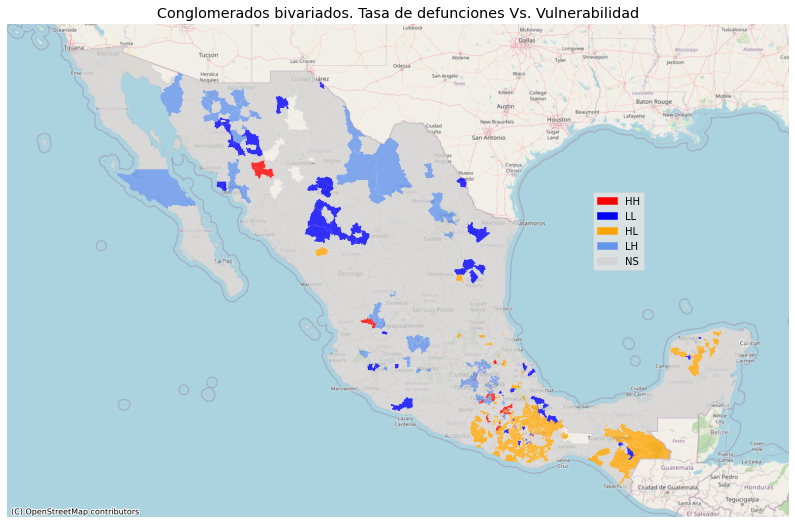

In [82]:
bivariado_defunciones = lisa_defunciones.merge(vulnerabilidad, on='municipio_cvegeo')
bivariado_defunciones = bivariado_defunciones.drop(['tasa_moran_local', 'cluster', 'tasa_p_sim'], axis=1)
bivariado_defunciones.loc[:,'tasa'] = (bivariado_defunciones['tasa'] - bivariado_defunciones['tasa'].mean())/bivariado_defunciones['tasa'].std()
bivariado_defunciones.loc[:,'pca_vulnerability'] = (bivariado_defunciones['pca_vulnerability'] - bivariado_defunciones['pca_vulnerability'].mean())/bivariado_defunciones['pca_vulnerability'].std()
bivariado_defunciones = bivariado_defunciones[bivariado_defunciones['pca_vulnerability'].isna() == False]
w_bivar = Queen.from_dataframe(bivariado_defunciones)
w_bivar.T = 'r' # estandarizamos por fila
w_bivar.n
local_bivar_defunciones = esda.Moran_Local_BV.by_col(bivariado_defunciones,'pca_vulnerability', 'tasa', w_bivar, permutations=10000, outvals=['q'])
local_bivar_defunciones.rename({'pca_vulnerability-tasa_q': 'cluster'}, inplace=True, axis=1)
local_bivar_defunciones.loc[local_bivar_defunciones['pca_vulnerability-tasa_p_sim'] > 0.05, 'cluster'] = -4
local_bivar_defunciones['cluster'] = local_bivar_defunciones['cluster'].replace({1: 'HH', 2: 'LH', 3:'LL', 4:'HL', -4:'NS'})
local_bivar_defunciones = gpd.geodataframe.GeoDataFrame(local_bivar_defunciones)
local_bivar_defunciones.crs = "EPSG:4326"

color_dict = {'HH':'red', 'LL':'blue', 'HL':'orange', 'LH':'cornflowerblue', 'NS':'lightgray'}
fig, ax = plt.subplots(figsize=(14, 16))
for ctype, data in local_bivar_defunciones.groupby('cluster'):
    color = color_dict[ctype]
    # Plot each group using the color defined above
    data.to_crs(epsg=3857).plot(color=color,
              ax=ax,
              label=ctype,
              alpha=0.8 )

red_patch = mpatches.Patch(color='red', label='HH')
blue_patch = mpatches.Patch(color='blue', label='LL')
orange_patch = mpatches.Patch(color='orange', label='HL')
lblue_patch = mpatches.Patch(color='cornflowerblue', label='LH')
gray_patch = mpatches.Patch(color='lightgray', label='NS')
plt.legend(handles=[red_patch, blue_patch, orange_patch, lblue_patch, gray_patch], loc=(0.75,0.5))
ax.set(title='Conglomerados bivariados. Tasa de defunciones Vs. Vulnerabilidad')
ax.set_axis_off()
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
plt.show()

En general, la interpretación de este mapa es similar a la de los conglomerados bivariados con la tasa de casos confirmados, aunque quizá sea menos informativo. Como vimos arriba, la tasa de casos tiene una clara estructura espacial que, además, obedece a la lógica de la epidemia: transimición por contacto. Sin embargo, no es claro que la tasa de defunciones obedezca a la misma lógica. Seguramente hay cierta estructura espacial porque a) las condiciones en lo municipios tienden a ser similares sólo por cercanía y b) las defunciones (en total) siguen una lógica parecida a la de los casos acumulados: entre más casos es más probable que haya defunciones.  